# ECCOv4 Loading llc binary files in the 'compact' format

## Objective

To teach how to loading ECCO binary files written by the MITgcm in the llc 'compact' format. 

## Introduciton

When the MITgcm saves diagnostic and other fields to files it does so using the so-called 'compact' format.  The compact format distributes the arrays from the 13 lat-lon-cap tiles in a somewhat unintuitive manner. Fortunately, it is not difficult to extract the 13 tiles from 'compact' format files. This tutorial will show you how to use the 'read_llc_to_tiles' subroutine to read and re-organize MITgcm's files written in compact format into a more familiar 13-tile layout.

## Objectives

By the end of the tutorial you will be able to read llc compact binary files of any dimension, plot them, and convert them into DataArrays.

In [1]:
## Import the ecco_v4_py library into Python
## =========================================

## -- If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  For example, if your ecco_v4_py
##    files are in /Users/ifenty/ECCOv4-py/ecco_v4_py, then use:
import sys

sys.path.append('/Users/ifenty/git_repos/my_forks/ECCOv4-py')
import ecco_v4_py as ecco

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

## The *read_llc_to_tiles* subroutine

*read_llc_to_tiles* reads a llc compact format binary file and converts to a numpy ndarray of dimension:
[N_recs, N_z, N_tiles, llc, llc]

For ECCOv4 our convention is:
```
'N_recs' = number of time levels
'N_z' = number of depth levels
'N_tiles' = 13
'llc' = 90
```

By default the routine will try to load a single 2D slice of a llc90 compact binary file: (N_recs = 1, N_z =1, N_tiles = 13, and llc=90).  

There are several other options which you can learn about using the 'help' command:

In [2]:
help(ecco.read_llc_to_tiles)

Help on function read_llc_to_tiles in module ecco_v4_py.read_bin_llc:

read_llc_to_tiles(fdir, fname, llc=90, skip=0, nk=1, nl=1, filetype='>f', less_output=False, use_xmitgcm=False)
    Loads an MITgcm binary file in the 'tiled' format of the 
    lat-lon-cap (LLC) grids with dimension order:
    
        [N_recs, N_z, N_tiles, llc, llc]
    
    where if either N_z or N_recs =1, then that dimension is collapsed
    and not present in the returned array.
    
    if use_xmitgcm == True
    
        data are read in via the low level routine 
        xmitgcm.utils.read_3d_llc_data and returned as dask array.
    
        Hint: use data_tiles.compute() to load into memory.
    
    if use_xmitgcm == False
    
        Loads an MITgcm binary file in the 'compact' format of the 
        lat-lon-cap (LLC) grids and converts it to the '13 tiles' format
        of the LLC grids.  
    
    Parameters
    ----------
    fdir : string
        A string with the directory of the binary file to o

## Related routines

Two related routines which you might find useful: 

1. *read_llc_to_compact*: Loads an MITgcm binary file in the 'compact' format of the 
    lat-lon-cap (LLC) grids and preserves its original dimension
    
2.  *read_llc_to_faces* : Loads an MITgcm binary file in the 'compact' format of the 
    lat-lon-cap (LLC) grids and converts it to the '5 faces' dictionary. 
    
For the remainder of the tutorial we will only use *read_llc_to_tiles*.

## Example 1: Load a 2D llc 'compact' binary file

The file 'bathy_eccollc_90x50_min2pts.bin' contains the 2D array of bathymetry for the model. 

In [3]:
input_dir = '/Users/ifenty/tmp/input_init/'
input_file = 'bathy_eccollc_90x50_min2pts.bin'

*read_llc_to_tiles* actually runs several other subroutines: *load_binary_array* which does the lower level reading of the binary file, *llc_compact_to_faces* which converts the array to 5 'faces', and finally *llc_faces_to_tiles* which extracts the 13 tiles from the 5 faces:

In [4]:
bathy = ecco.read_llc_to_tiles(input_dir, input_file)

load_binary_array: loading file /Users/ifenty/tmp/input_init/bathy_eccollc_90x50_min2pts.bin
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


*bathy* is a numpy float32 array with dimension [13, 90, 90]

### Plot the 13 tiles bathymetry data 

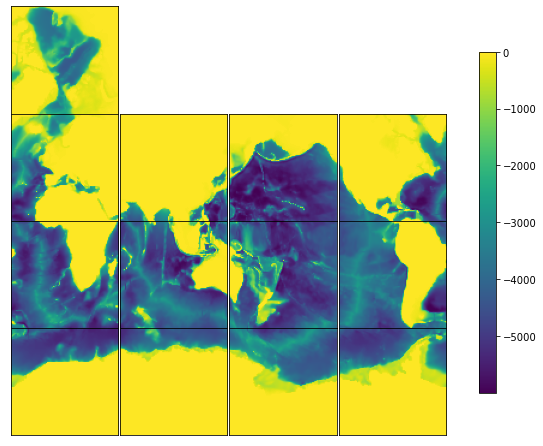

In [5]:
# Use plot_tiles to make a quick plot of the 13 tiles.  See the tutorial on plotting for more examples.
ecco.plot_tiles(bathy, layout='latlon',rotate_to_latlon=True,show_tile_labels=False, show_colorbar=True);

## Load ecco-grid information to make a fancier lat-lon plot

With the longitudes (XC) and latitudes (YC) and the 13 tile ndarray we can plot the field in different geographic projections.  See the tutorial on plotting for more examples.

In [6]:
ecco_grid_dir = '/Users/ifenty/tmp/nctiles_grid/'
ecco_grid = ecco.load_ecco_grid_nc(input_dir, 'ECCO-GRID.nc')

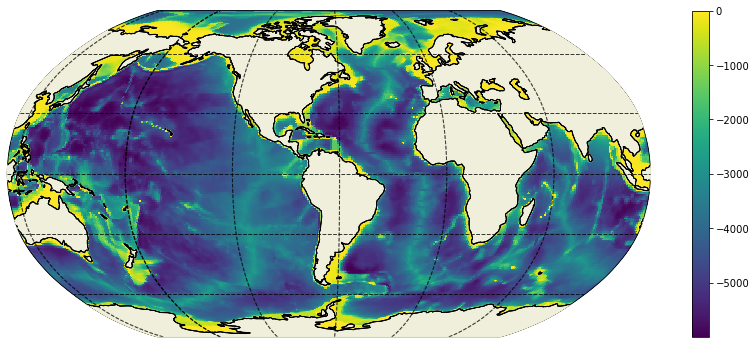

In [7]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, bathy, show_colorbar=True, user_lon_0=-66);

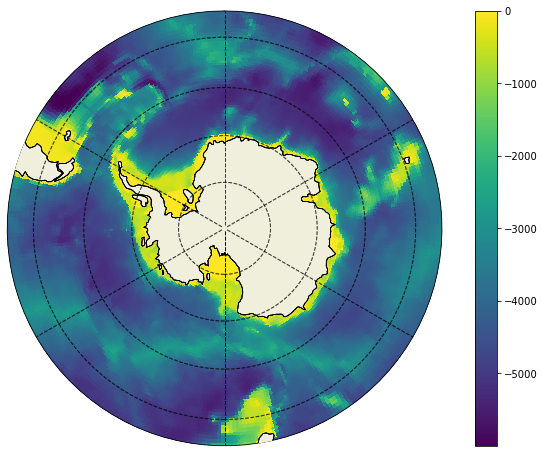

In [8]:
plt.figure(figsize=(12,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, bathy, show_colorbar=True,\
                              projection_type='stereo', lat_lim =-45, less_output=True,dx=.25,dy=.25);

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.  One approach is to create the DataArray manually by specifying the names and values of the new dimension coordinates: 

In [9]:
tile = range(13)
i = range(90)
j = range(90)

In [10]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
bathy_DA = xr.DataArray(bathy,coords={'tile': tile,
                                         'j': j,
                                         'i': i}, dims=['tile','j','i'])

In [11]:
print(bathy_DA.dims)

('tile', 'j', 'i')


Another approach is to use the routine *llc_tiles_to_xda*.  *llc_tiles_to_xda* uses 

In [12]:
bathy.shape

(13, 90, 90)

In [13]:
bathy_DA2 = ecco.llc_tiles_to_xda(bathy, var_type='c',grid_da=ecco_grid.XC)
print(bathy_DA2.dims)
print(bathy_DA2.coords)

('tile', 'j', 'i')
Coordinates:
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.60647 -111.303 ... -105.58465 -111.86579
    YC       (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    CS       (tile, j, i) float32 0.06157813 0.06675376 ... -0.9983638
    SN       (tile, j, i) float32 -0.99810225 -0.9977695 ... -0.057182025
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0


## Example 2: Load a 3D 'compact' llc binary file with 3rd dimension = Time


The file 'runoff-2d-Fekete-1deg-mon-V4-SMOOTH.bin' contains the 12 month climatology of river runoff, dimensions of [time, j, i].  

In [14]:
input_file = 'runoff-2d-Fekete-1deg-mon-V4-SMOOTH.bin'

specify the length of the n_recs dimension, nl, as 12. By default, nk = 1

In [15]:
runoff = ecco.read_llc_to_tiles(input_dir, input_file, nl=12)

load_binary_array: loading file /Users/ifenty/tmp/input_init/runoff-2d-Fekete-1deg-mon-V4-SMOOTH.bin
load_binary_array: data array shape  (12, 1, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (12, 1, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (12, 1, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


Shape is n_recs (12), n_z (1), n_tiles (13), llc (90), llc (90)

In [16]:
print(runoff.shape)

(12, 1, 13, 90, 90)


### Plot the November runoff climatology

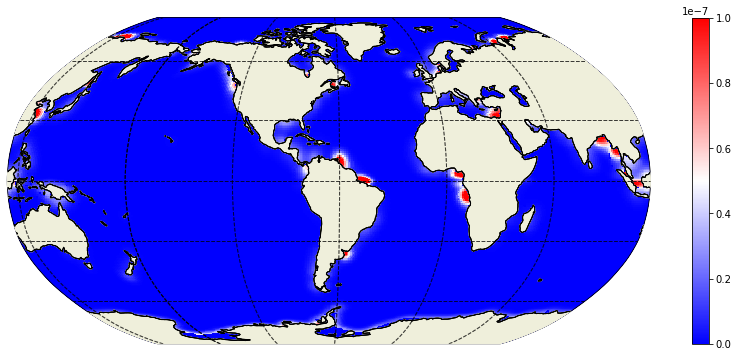

In [17]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, runoff[10,:], cmin=0,cmax=1e-7,\
                              show_colorbar=True, cmap='bwr',user_lon_0=-66);

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.  Two methods: 'manual' and using *llc_tiles_to_xda*.

### Method 1: Manual

In [18]:
tile = range(1,14)
i = range(90)
j = range(90)
time = range(12) # months
k = [0];

In [19]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
runoff_DA = xr.DataArray(runoff,coords={'time': time,
                                        'k': k,
                                        'tile': tile,
                                        'j': j,
                                        'i': i}, dims=['time','k','tile','j','i'])

In [20]:
print(runoff_DA.dims)
print(runoff_DA.shape)

('time', 'k', 'tile', 'j', 'i')
(12, 1, 13, 90, 90)


### Method 2: *llc_tiles_to_xda*

runoff is a 3D array with the 3rd dimension being time and therefore we need to pass *llc_tiles_to_xda* a similarly-dimensioned DataArray or tell the subroutine that the 3rd dimension is depth. The 'ecco_grid' DataSet doesn't have any similary-dimensioned DataArrays (no DataArrays with a time dimension). Therefore we will tell the routine that the new 4th dimension should be time:

In [21]:
##### specify that the 5th dimension should be time
runoff_DA2 = ecco.llc_tiles_to_xda(runoff, var_type='c',dim4='depth', dim5='time')
print(runoff_DA2.dims)
print(runoff_DA2.coords)

('time', 'k', 'tile', 'j', 'i')
Coordinates:
  * k        (k) int64 0
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89


## Example 3: Load a 3D 'compact' llc binary file with 3rd dimension = Depth


The file 'total_kapredi_r009bit11.bin' is a 50 depth level array of the adjusted Redi parameter from Release 1 (first guess + adjustments), dimensions of [depth, j, i].
<br>Release 4's adjusted Redi parameter can be found at https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_OCEAN_3D_MIX_COEFFS_LLC0090GRID_V4R4/OCEAN_3D_MIXING_COEFFS_ECCO_V4r4_native_llc0090.nc.

In [22]:
input_file = 'total_kapredi_r009bit11.bin'

specify the number of depth levels as 50.  n_recs defaults to 1 and is dropped by default.

In [23]:
kapredi = ecco.read_llc_to_tiles(input_dir, input_file, nk=50)

load_binary_array: loading file /Users/ifenty/tmp/input_init/total_kapredi_r009bit11.bin
load_binary_array: data array shape  (50, 1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (50, 1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (50, 13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [24]:
print(kapredi.shape)

(50, 13, 90, 90)


### Plot log10 of the parameter at the 10th depth level (105m)

<ipython-input-25-b09b1aa1ac7e>:2: RuntimeWarning: divide by zero encountered in log10
  ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, np.log10(kapredi[10,:]),\


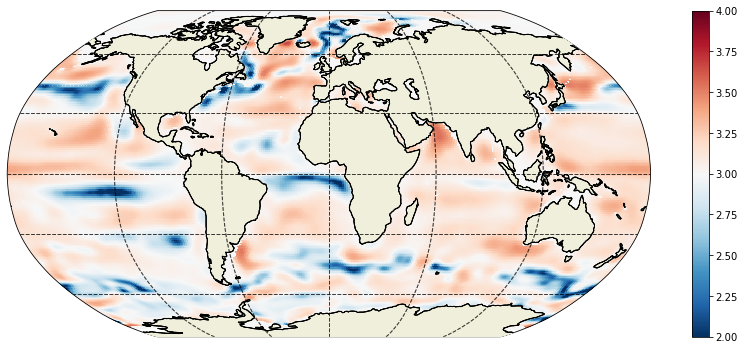

In [25]:
plt.figure(figsize=(15,6));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, np.log10(kapredi[10,:]),\
                              cmin=2,cmax=4,show_colorbar=True);

## Convert the ndarray into a DataArray

Converting the ndarray to a DataArray can be useful for broadcasting operations.  Two methods: 'manual' and using *llc_tiles_to_xda*.

### Method 1: Manual

In [26]:
tile = range(1,14)
i = range(90)
j = range(90)
k = range(50)

In [27]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
kapredi_DA = xr.DataArray(kapredi,coords={'k': k,
                                          'tile': tile,
                                          'j': j,
                                          'i': i},dims=['k','tile','j','i'])

In [28]:
print(kapredi_DA.dims)
print(kapredi_DA.shape)

('k', 'tile', 'j', 'i')
(50, 13, 90, 90)


### Method 2: *llc_tiles_to_xda*

kapredi is a 4D array (depth, tile, j, i) and therefore we need to pass *llc_tiles_to_xda* a similarly-dimensioned DataArray or tell the subroutine that the 4th dimension is depth

In [29]:
# use similarly-dimensioned DataArray: hFacC
kapredi_DA2 = ecco.llc_tiles_to_xda(kapredi, var_type='c',grid_da=ecco_grid.hFacC)
print(kapredi_DA2.dims)
print(kapredi_DA2.coords)

('k', 'tile', 'j', 'i')
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.60647 -111.303 ... -105.58465 -111.86579
    YC       (tile, j, i) float32 -88.24259 -88.382515 ... -88.07871 -88.10267
    CS       (tile, j, i) float32 0.06157813 0.06675376 ... -0.9983638
    SN       (tile, j, i) float32 -0.99810225 -0.9977695 ... -0.057182025
    Z        (k) float32 -5.0 -15.0 -25.0 -35.0 ... -5039.25 -5461.25 -5906.25
    Depth    (tile, j, i) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    rA       (tile, j, i) float32 362256450.0 363300960.0 ... 361119100.0
    PHrefC   (k) float32 49.05 147.15 245.25 ... 49435.043 53574.863 57940.312
    drF      (k) float32 10.0 10.0 10.0 10.0 10.0 ... 

In [30]:
# specify that the 4th dimension should be depth
kapredi_DA3 = ecco.llc_tiles_to_xda(kapredi, var_type='c', dim4='depth')
print(kapredi_DA3.dims)
print(kapredi_DA3.coords)

('k', 'tile', 'j', 'i')
Coordinates:
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * tile     (tile) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89


## Parting thoughts

1. *read_llc_to_tiles* can also be used to read ECCO '*.data'* generated when re-running the ECCO model.

1. Converting from numpy ndarrays or xarray DataArrays in the 'tile' format to a 5-faces format or compact format can be made with routines like: *llc_tiles_to_compact* and *llc_tiles_to_faces*

### *llc_tiles_to_faces*

In [31]:
help(ecco.llc_tiles_to_faces)

Help on function llc_tiles_to_faces in module ecco_v4_py.llc_array_conversion:

llc_tiles_to_faces(data_tiles, less_output=False)
    Converts an array of 13 'tiles' from the lat-lon-cap grid
    and rearranges them to 5 faces.  Faces 1,2,4, and 5 are approximately 
    lat-lon while face 3 is the Arctic 'cap' 
    
    Parameters
    ----------
    data_tiles : 
        An array of dimension 13 x nl x nk x llc x llc
        
    If dimensions nl or nk are singular, they are not included 
        as dimensions of data_tiles    
    
    less_output : boolean
        A debugging flag.  False = less debugging output
        Default: False
    
    Returns
    -------
    F : dict
        a dictionary containing the five lat-lon-cap faces
        
        F[n] is a numpy array of face n, n in [1..5]
    
        dimensions of each 2D slice of F
        
        - f1,f2: 3*llc x llc
        -    f3: llc x llc
        - f4,f5: llc x 3*llc



### *llc_tiles_to_compact*

In [32]:
help(ecco.llc_tiles_to_compact)

Help on function llc_tiles_to_compact in module ecco_v4_py.llc_array_conversion:

llc_tiles_to_compact(data_tiles, less_output=False)
    Converts a numpy binary array in the 'compact' format of the 
    lat-lon-cap (LLC) grids and converts it to the '13 tiles' format
    of the LLC grids.  
    
    Parameters
    ----------
    data_tiles : ndarray
        a numpy array organized by, at most, 
        13 tiles x nl x nk x llc x llc
    
        where dimensions 'nl' and 'nk' are optional.
        
    less_output : boolean, optional, default False
        A debugging flag.  False = less debugging output
        
    Returns
    -------
    data_compact : ndarray
        a numpy array of dimension nl x nk x 13*llc x llc 
    
    Note
    ----
    If dimensions nl or nk are singular, they are not included 
    as dimensions in data_compact

